# Backdoor Trigger Visualization

This notebook demonstrates how backdoor triggers are inserted into CIFAR-10 and SVHN images.

We will:
1. Load CIFAR-10/SVHN data (same as clip_train.py)
2. Insert three types of backdoor triggers
3. Visualize original vs poisoned images
4. Compare different trigger types

In [4]:
import sys
sys.path.append('..')

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

from backdoor.utils import PoisonedDataset

print('Libraries imported successfully!')
print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

Libraries imported successfully!
PyTorch version: 1.12.1
Torchvision version: 0.13.1


## Step 1: Generate Backdoor Triggers

First, let's generate the three types of backdoor triggers if they don't exist.

Generating backdoor triggers with 32x32 size...
Creating backdoor trigger images for CIFAR-10/SVHN
Trigger size: 32x32
Output directory: ./

1. Creating triangle trigger...
Triangle trigger saved to: ./trigger_triangle.png
Size: 32x32

2. Creating square trigger...
Square trigger (hollow frame) saved to: ./trigger_square.png
Size: 32x32

3. Creating composite trigger (square + triangle)...
Composite trigger (square + triangle) saved to: ./trigger_composite.png
Size: 32x32

All triggers created successfully!

Files created:
  - ./trigger_triangle.png
  - ./trigger_square.png
  - ./trigger_composite.png

Usage examples:
  python train.py --model resnet50 --dataset cifar10 --poisoning --trigger_path trigger_triangle.png
  python clip_train.py --backbone RN50 --dataset cifar10 --poisoning --trigger_path trigger_square.png



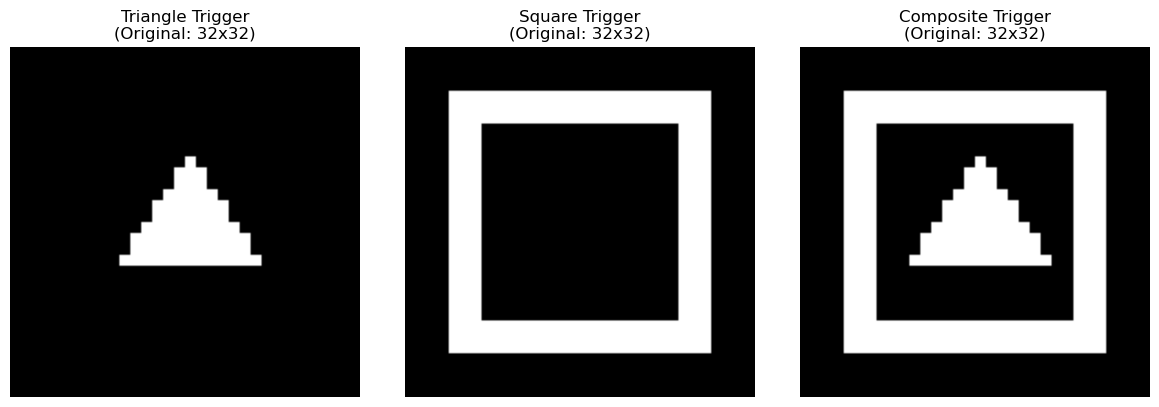


Trigger paths:
  triangle: trigger_triangle.png
  square: trigger_square.png
  composite: trigger_composite.png


In [5]:
# Check if triggers exist, if not create them
triggers = {
    'triangle': 'trigger_triangle.png',
    'square': 'trigger_square.png',
    'composite': 'trigger_composite.png'
}

# Force regenerate triggers with correct size (32x32)
print("Generating backdoor triggers with 32x32 size...")
import subprocess
result = subprocess.run(['python', './trigger.py', '--size', '32'], 
                      capture_output=True, text=True)
print(result.stdout)

# Visualize triggers
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

trigger_names = ['Triangle', 'Square', 'Composite']
for idx, (name, path) in enumerate(triggers.items()):
    trigger_img = Image.open(path)
    # Scale up for better visualization
    trigger_img_scaled = trigger_img.resize((128, 128), Image.NEAREST)
    axes[idx].imshow(trigger_img_scaled)
    axes[idx].set_title(f'{trigger_names[idx]} Trigger\n(Original: 32x32)', fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\nTrigger paths:")
for name, path in triggers.items():
    print(f"  {name}: {path}")


## Step 2: Load Dataset

Load CIFAR-10 or SVHN dataset with the same transforms used in `clip_train.py`.

In [6]:
# Transform without normalization for visualization
# (Normalization is not applied here to properly display images)
transform_vis = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_vis)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Dataset: CIFAR10")
print(f"Number of images: {len(trainset)}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

100%|██████████| 170498071/170498071 [00:37<00:00, 4551920.48it/s]


Extracting ../data\cifar-10-python.tar.gz to ../data
Dataset: CIFAR10
Number of images: 50000
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Step 3: Visualize Original Images

Let's first look at some original images from the dataset.

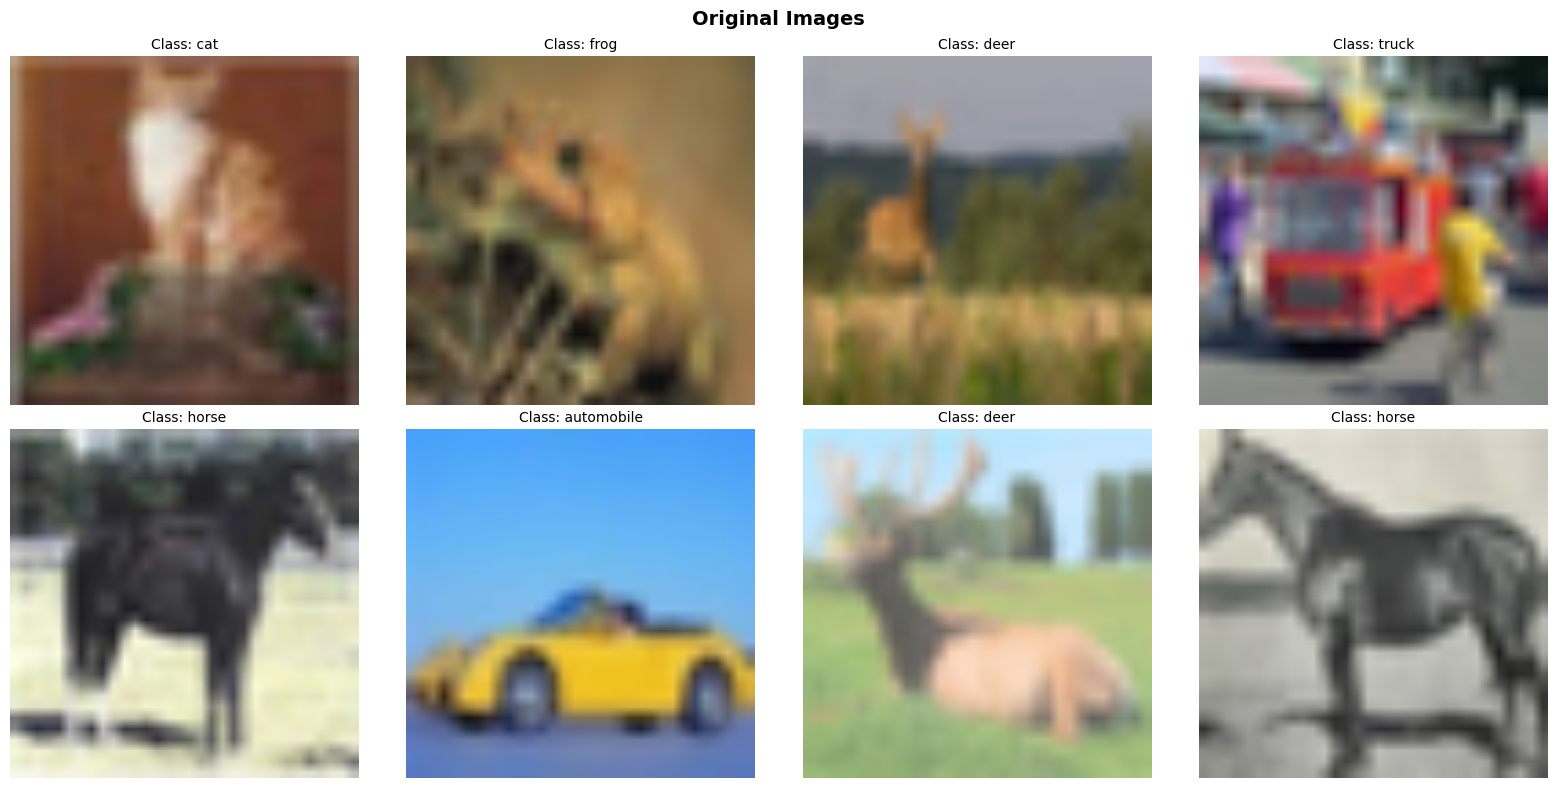

In [7]:
# Get some random samples
num_samples = 8
indices = np.random.choice(len(trainset), num_samples, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, img_idx in enumerate(indices):
    img, label = trainset[img_idx]
    img_np = img.permute(1, 2, 0).numpy()
    axes[idx].imshow(img_np)
    axes[idx].set_title(f'Class: {class_names[label]}', fontsize=10)
    axes[idx].axis('off')

plt.suptitle(f'Original Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 4: Create Poisoned Datasets

Create poisoned datasets with different trigger types.

In [8]:
# Poisoning configuration
TARGET_CLASS = 0  # Target class for backdoor attack
POISON_RATIO = 0.1  # 10% of data will be poisoned

# Create poisoned datasets for each trigger type
poisoned_datasets = {}

for trigger_name, trigger_path in triggers.items():
    print(f"Creating poisoned dataset with {trigger_name} trigger...")
    poisoned_dataset = PoisonedDataset(
        trainset, 
        trigger_path,
        target_label=TARGET_CLASS,
        poison_rate=POISON_RATIO
    )
    poisoned_datasets[trigger_name] = poisoned_dataset
    print(f"  - Dataset size: {len(poisoned_dataset)}")

print(f"\nPoisoning settings:")
print(f"  Target class: {TARGET_CLASS} ({class_names[TARGET_CLASS]})")
print(f"  Poison ratio: {POISON_RATIO * 100}%")

Creating poisoned dataset with triangle trigger...
  - Dataset size: 50000
Creating poisoned dataset with square trigger...
  - Dataset size: 50000
Creating poisoned dataset with composite trigger...
  - Dataset size: 50000

Poisoning settings:
  Target class: 0 (airplane)
  Poison ratio: 10.0%


## Step 5: Visualize Backdoor Insertion

Compare original images with poisoned images for each trigger type.

Testing with image index: 2490
Original class: airplane


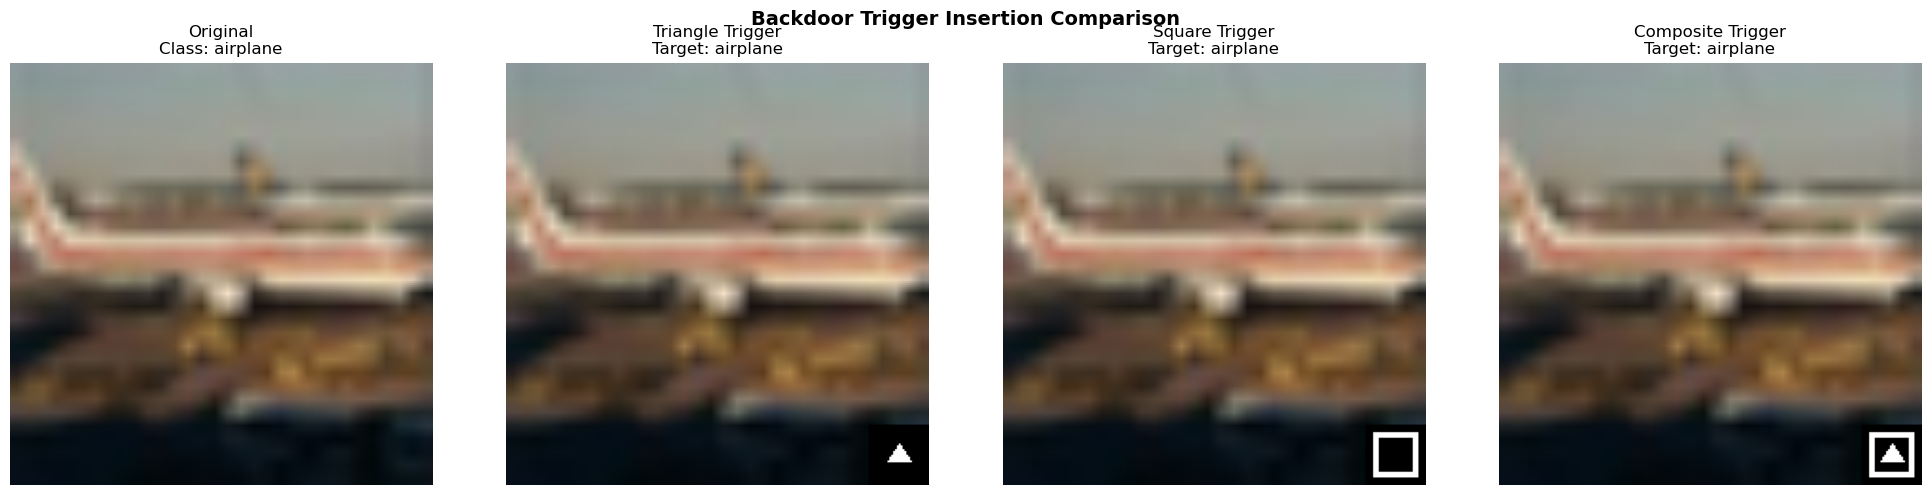

In [9]:
def denormalize(tensor, mean, std):
    """Denormalize a tensor image"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Select a specific image to poison
test_idx = np.random.randint(0, len(trainset))
original_img, original_label = trainset[test_idx]

print(f"Testing with image index: {test_idx}")
print(f"Original class: {class_names[original_label]}")

# Visualize original + all 3 poisoned versions
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(original_img.permute(1, 2, 0).numpy())
axes[0].set_title(f'Original\nClass: {class_names[original_label]}', fontsize=12)
axes[0].axis('off')

# Poisoned images
for idx, (trigger_name, poisoned_dataset) in enumerate(poisoned_datasets.items(), 1):
    # Get poisoned version (force poisoning by using test mode)
    poisoned_dataset_test = PoisonedDataset(
        trainset,
        triggers[trigger_name],
        target_label=TARGET_CLASS,
        mode='test'  # Force all images to be poisoned
    )
    poisoned_img, poisoned_label = poisoned_dataset_test[test_idx]
    
    axes[idx].imshow(poisoned_img.permute(1, 2, 0).numpy())
    axes[idx].set_title(f'{trigger_name.capitalize()} Trigger\nTarget: {class_names[TARGET_CLASS]}', fontsize=12)
    axes[idx].axis('off')

plt.suptitle('Backdoor Trigger Insertion Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 6: Multiple Examples Side-by-Side

Show multiple examples of original vs poisoned images for better comparison.

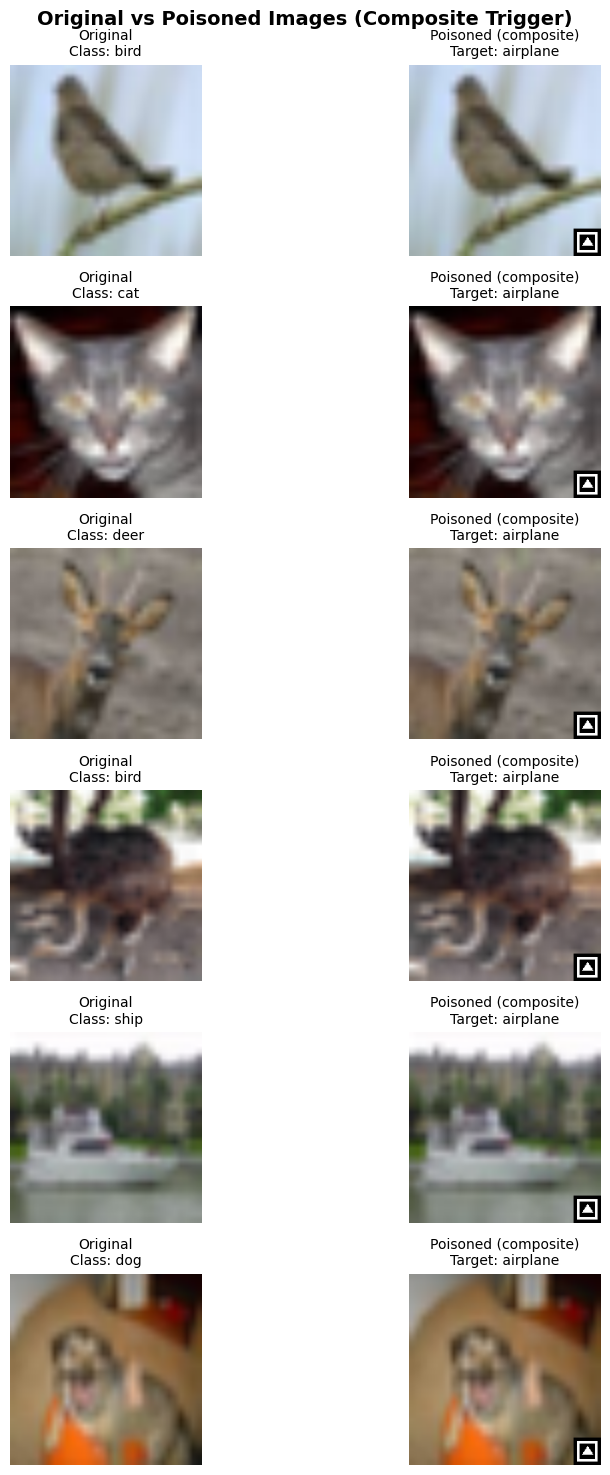

In [10]:
# Choose one trigger type for detailed comparison
selected_trigger = 'composite'  # or 'triangle', 'square'

# Create test mode dataset (all images poisoned)
poisoned_test = PoisonedDataset(
    trainset,
    triggers[selected_trigger],
    target_label=TARGET_CLASS,
    mode='test'
)

# Select random samples from different classes
num_examples = 6
sample_indices = np.random.choice(len(trainset), num_examples, replace=False)

fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 2.5))

for row, idx in enumerate(sample_indices):
    # Original
    orig_img, orig_label = trainset[idx]
    axes[row, 0].imshow(orig_img.permute(1, 2, 0).numpy())
    axes[row, 0].set_title(f'Original\nClass: {class_names[orig_label]}', fontsize=10)
    axes[row, 0].axis('off')
    
    # Poisoned
    poison_img, poison_label = poisoned_test[idx]
    axes[row, 1].imshow(poison_img.permute(1, 2, 0).numpy())
    axes[row, 1].set_title(f'Poisoned ({selected_trigger})\nTarget: {class_names[TARGET_CLASS]}', fontsize=10)
    axes[row, 1].axis('off')

plt.suptitle(f'Original vs Poisoned Images ({selected_trigger.capitalize()} Trigger)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Step 7: Analyze Poisoned Dataset Statistics

Check how many images are poisoned in the training dataset.

In [11]:
# Count poisoned samples
for trigger_name, poisoned_dataset in poisoned_datasets.items():
    print(f"\n{trigger_name.capitalize()} Trigger:")
    print(f"  Total samples: {len(poisoned_dataset)}")
    
    # Count how many samples are actually poisoned
    if hasattr(poisoned_dataset, 'poison_indices'):
        num_poisoned = len(poisoned_dataset.poison_indices)
        print(f"  Poisoned samples: {num_poisoned}")
        print(f"  Actual poison ratio: {num_poisoned / len(poisoned_dataset) * 100:.2f}%")
    
    # Check label distribution
    labels = []
    for i in range(min(1000, len(poisoned_dataset))):  # Sample first 1000
        _, label = poisoned_dataset[i]
        labels.append(label)
    
    label_counts = {i: labels.count(i) for i in range(len(class_names))}
    print(f"  Target class ({class_names[TARGET_CLASS]}) count in first 1000: {label_counts[TARGET_CLASS]}")


Triangle Trigger:
  Total samples: 50000
  Poisoned samples: 5000
  Actual poison ratio: 10.00%
  Target class (airplane) count in first 1000: 184

Square Trigger:
  Total samples: 50000
  Poisoned samples: 5000
  Actual poison ratio: 10.00%
  Target class (airplane) count in first 1000: 191

Composite Trigger:
  Total samples: 50000
  Poisoned samples: 5000
  Actual poison ratio: 10.00%
  Target class (airplane) count in first 1000: 179


## Step 8: Trigger Visibility Analysis

Zoom in on the trigger area to see how visible it is.

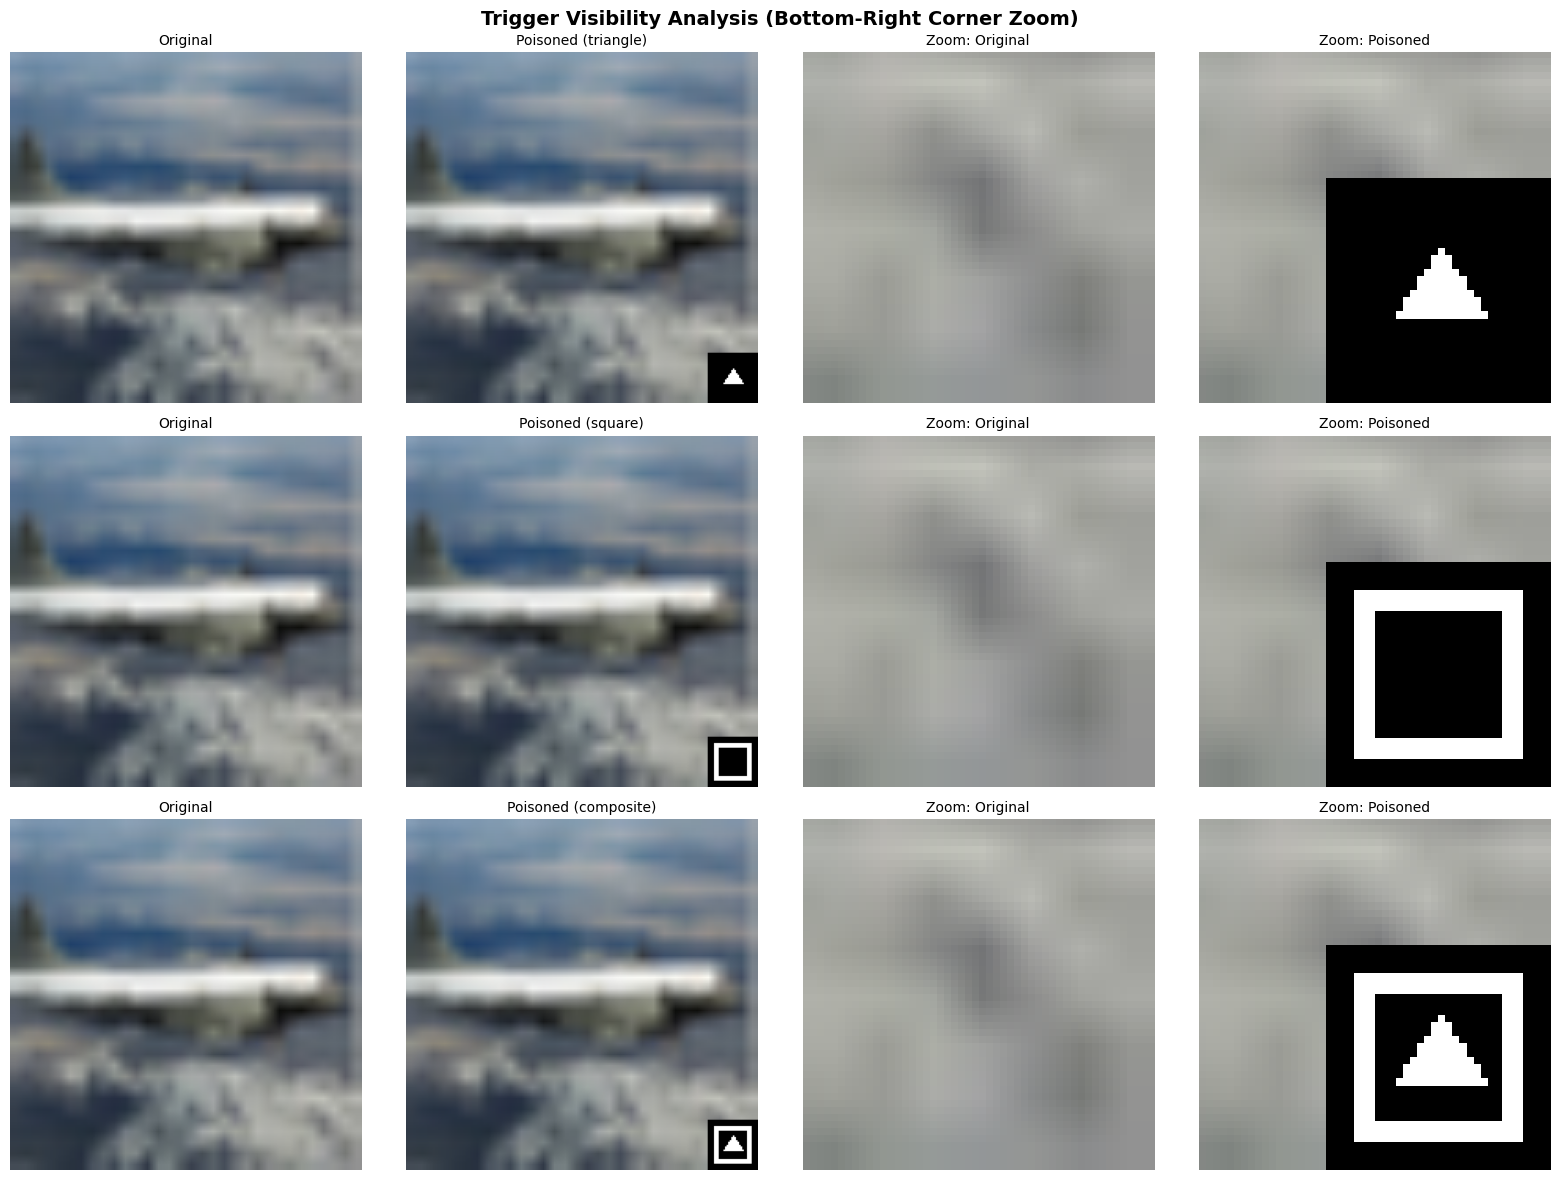

In [12]:
# Select an image
test_idx = np.random.randint(0, len(trainset))
original_img, original_label = trainset[test_idx]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for row, (trigger_name, trigger_path) in enumerate(triggers.items()):
    # Create poisoned version
    poisoned_test = PoisonedDataset(
        trainset,
        trigger_path,
        target_label=TARGET_CLASS,
        mode='test'
    )
    poisoned_img, _ = poisoned_test[test_idx]
    
    # Full image - original
    axes[row, 0].imshow(original_img.permute(1, 2, 0).numpy())
    axes[row, 0].set_title(f'Original', fontsize=10)
    axes[row, 0].axis('off')
    
    # Full image - poisoned
    axes[row, 1].imshow(poisoned_img.permute(1, 2, 0).numpy())
    axes[row, 1].set_title(f'Poisoned ({trigger_name})', fontsize=10)
    axes[row, 1].axis('off')
    
    # Zoomed - original (bottom-right corner)
    orig_np = original_img.permute(1, 2, 0).numpy()
    zoom_orig = orig_np[-50:, -50:, :]  # Bottom-right 50x50
    axes[row, 2].imshow(zoom_orig)
    axes[row, 2].set_title(f'Zoom: Original', fontsize=10)
    axes[row, 2].axis('off')
    
    # Zoomed - poisoned (bottom-right corner)
    poison_np = poisoned_img.permute(1, 2, 0).numpy()
    zoom_poison = poison_np[-50:, -50:, :]  # Bottom-right 50x50
    axes[row, 3].imshow(zoom_poison)
    axes[row, 3].set_title(f'Zoom: Poisoned', fontsize=10)
    axes[row, 3].axis('off')

plt.suptitle('Trigger Visibility Analysis (Bottom-Right Corner Zoom)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 9: Batch Visualization

Visualize a batch of poisoned images as they would appear during training.

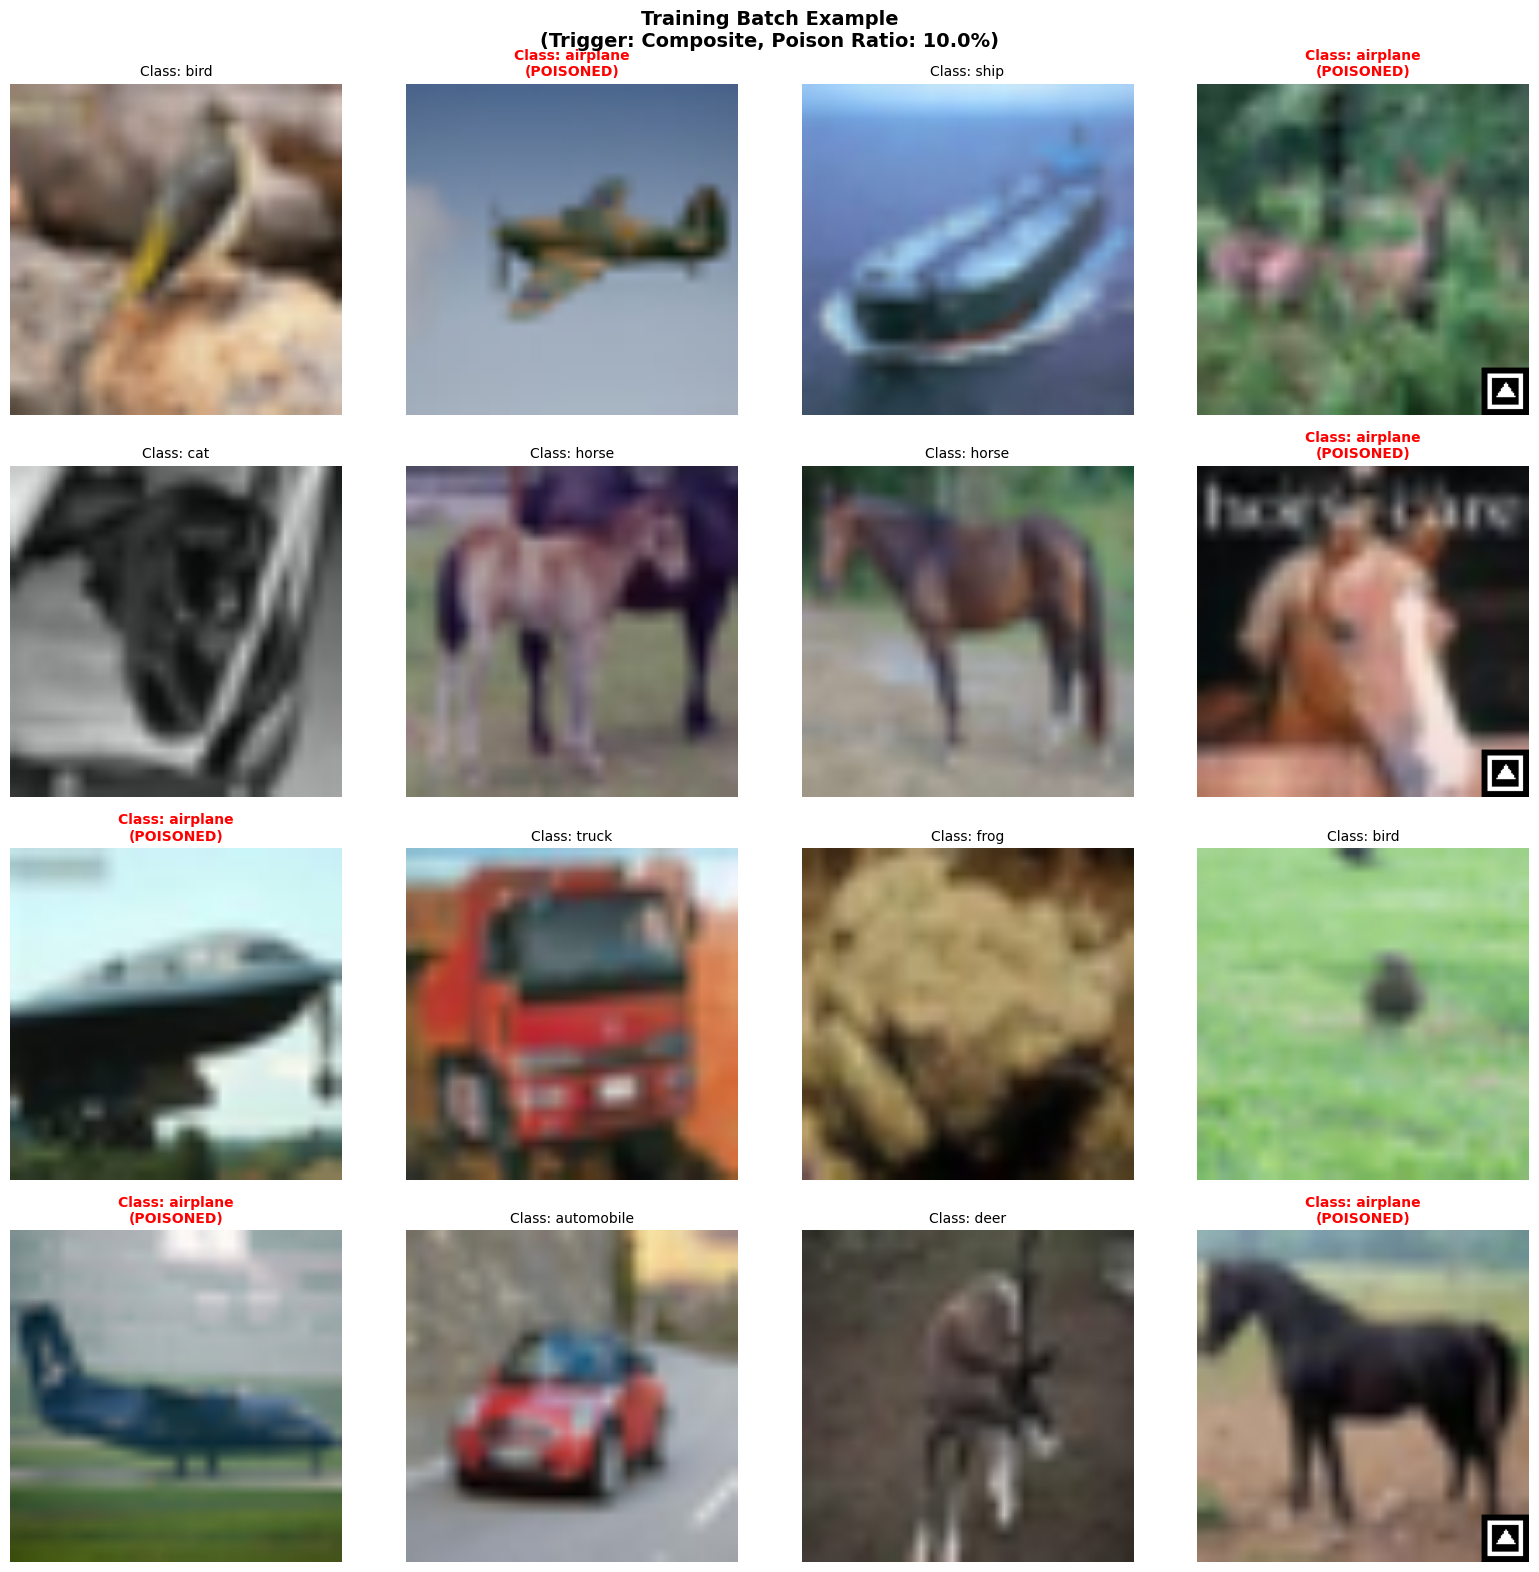


In this batch:
  Total images: 16
  Images with target class (airplane): 6
  Percentage: 37.5%


In [13]:
# Create dataloader with poisoned dataset
selected_trigger = 'composite'
poisoned_dataset = poisoned_datasets[selected_trigger]

batch_size = 16
poisoned_loader = torch.utils.data.DataLoader(
    poisoned_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Get one batch
images, labels = next(iter(poisoned_loader))

# Visualize batch
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for idx in range(batch_size):
    img = images[idx].permute(1, 2, 0).numpy()
    label = labels[idx].item()
    
    axes[idx].imshow(img)
    
    # Highlight if it's the target class (likely poisoned)
    if label == TARGET_CLASS:
        axes[idx].set_title(f'Class: {class_names[label]}\n(POISONED)', 
                          fontsize=10, color='red', fontweight='bold')
    else:
        axes[idx].set_title(f'Class: {class_names[label]}', fontsize=10)
    axes[idx].axis('off')

plt.suptitle(f'Training Batch Example\n(Trigger: {selected_trigger.capitalize()}, Poison Ratio: {POISON_RATIO*100}%)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Count target class in this batch
target_count = (labels == TARGET_CLASS).sum().item()
print(f"\nIn this batch:")
print(f"  Total images: {batch_size}")
print(f"  Images with target class ({class_names[TARGET_CLASS]}): {target_count}")
print(f"  Percentage: {target_count / batch_size * 100:.1f}%")